In [1]:
!pip install cspy

In [2]:
!pip install networkx==2.8.7

In [3]:
import networkx as nx
from networkx import DiGraph
import matplotlib.pyplot as plt
import numpy as np
from heapq import heappush, heappop
from itertools import count
import requests
import pprint
from heapdict import heapdict
from cspy import BiDirectional

In [4]:
# 最短経路問題の簡単なものを求解してみる
D = nx.DiGraph()
D.add_weighted_edges_from(
    [("s", 1, 10), ("s", 2, 5), (2, 1, 3), (1, "t", 4), (2, 3, 2), (3, "t", 6)]
)

pred, distance = nx.dijkstra_predecessor_and_distance(D, source="s") # source で始点を決定している
print(pred)
print(distance)

{'s': [], 1: [2], 2: ['s'], 3: [2], 't': [1]}
{'s': 0, 2: 5, 3: 7, 1: 8, 't': 12}


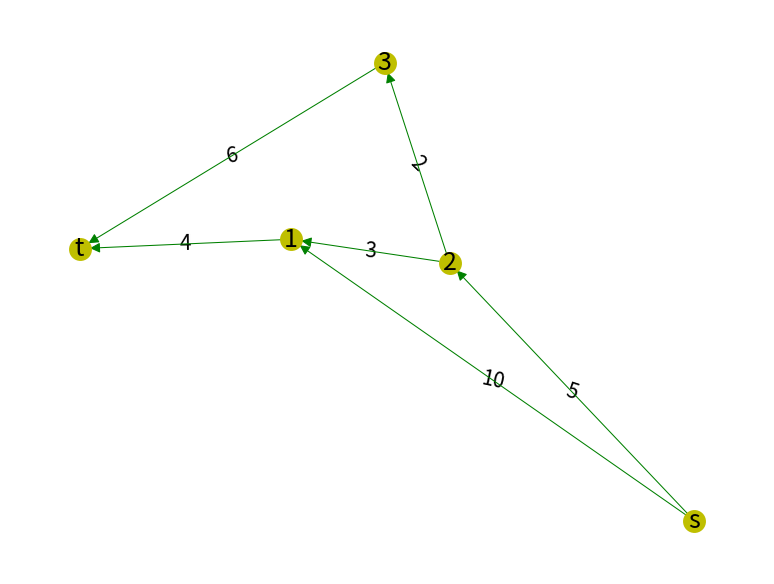

In [8]:
# 可視化してみる
# 結果と照らし合わせるとわかるけど、各nodeに対しての最短路を出しているので、終点までの中で通らないnodeが存在する場合もある。
# 今回でいうと、tまで移動するにあたっての最短経路として、node3は通らない。
edge_labels = {}
pos = nx.kamada_kawai_layout(D)
for (i,j) in D.edges():
    edge_labels[i, j] = f"{ D[i][j]['weight'] }"
nx.draw_networkx_edge_labels(D, pos=pos, edge_labels=edge_labels)
nx.draw(
    D, node_size=100, pos=pos, node_color="y", edge_color="g", width=.5, with_labels=True
)
plt.show()

ランダムな格子グラフを考えてみる。各枝のコストは一様分布で与える

In [9]:
import random
m, n = 1000, 1000 # m×nの格子グラフ
lb, ub = 1, 300
G = nx.grid_2d_graph(m,n)
for (i, j) in G.edges():
    G[i][j]["weight"] = random.randint(lb, ub)

In [10]:
%%time
pred, distance = nx.dijkstra_predecessor_and_distance(G, source=(0,0))

CPU times: user 5.35 s, sys: 91 ms, total: 5.44 s
Wall time: 5.45 s


In [15]:
## もう少し小さい格子グラフで考える
m, n = 10, 10 # m×nの格子グラフ
lb, ub = 1, 300
G = nx.grid_2d_graph(m,n)
for (i, j) in G.edges():
    G[i][j]["weight"] = random.randint(lb, ub)

pred, distance = nx.dijkstra_predecessor_and_distance(G, source=(0,0))

print("minimize cost= ", distance[m-1, n-1]) #最後の一つ手前まで
i = (m-1, n-1)
path = []
# 逆順でpathを追加していく
while i != (0,0):
    path.append(i)
    i = pred[i][0]
path.reverse()
print("optimal path =", path)

minimize cost=  1629
optimal path = [(1, 0), (1, 1), (1, 2), (2, 2), (2, 3), (3, 3), (4, 3), (5, 3), (6, 3), (6, 4), (6, 5), (7, 5), (7, 6), (7, 7), (7, 8), (8, 8), (8, 9), (9, 9)]


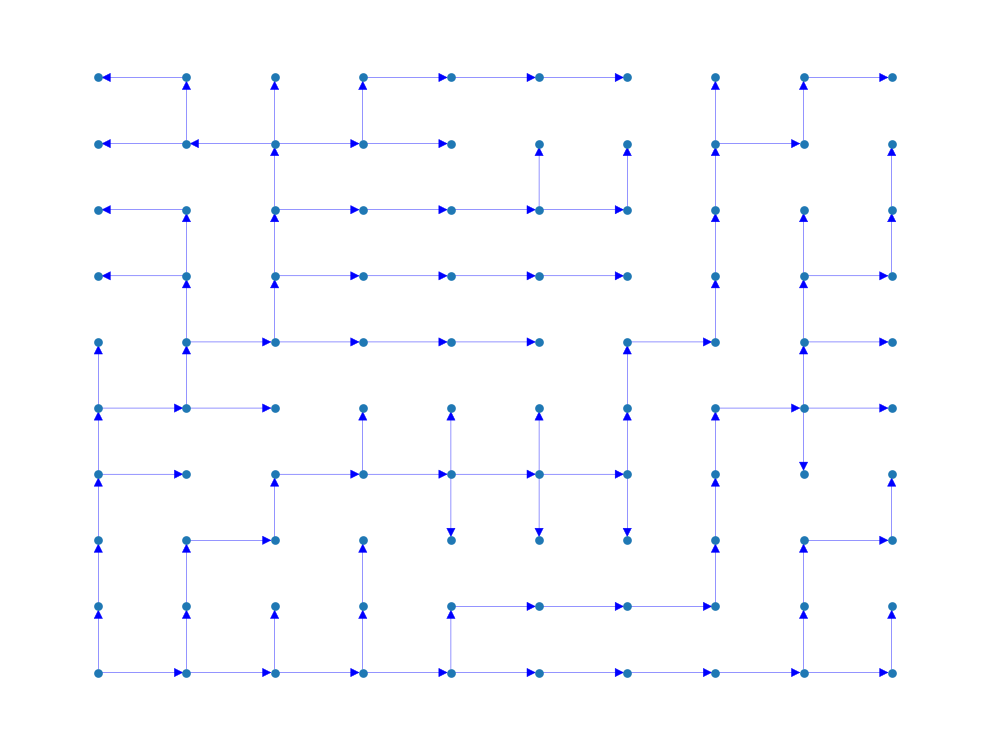

In [19]:
D = nx.DiGraph()
for i in pred:
    if len(pred[i]) >= 1:
        D.add_edge(pred[i][0], i)
pos = {(i, j): (i, j) for (i,j) in G.nodes()}
plt.figure()
nx.draw(D, pos=pos, width=0.2, edge_color="b", node_size=10)
plt.show()

In [23]:
# 重みに負が含まれる場合
import time
m, n = 10, 10 # m×nの格子グラフ
lb, ub = -100, 100
G = nx.grid_2d_graph(m,n)
D = G.to_directed()
for (i,j) in D.edges():
    D[i][j]["weight"] = random.randint(lb,ub)

start_time = time.time()
pred, distance = {}, {}
try:
    pred, distance = nx.bellman_ford_predecessor_and_distance(D, source=(0,0), heuristic=False)
except nx.NetworkXUnbounded as e:
    print(e)

end_time = time.time()
times = end_time - start_time
print(times)

Negative cycle detected.
0.0008904933929443359


In [24]:
# 時間を考慮した場合
def arrival_func(interval, velocity, distance):
    n = len(interval)
    b = []  # 到着時刻関数が (interval,b) を通過
    a = []  # 到着時刻関数の傾き
    for i, t in enumerate(interval):
        # 待ちなしの場合
        b.append(interval[i] + distance / velocity[i])  # start time + travel time
        a.append(1)
    # 待ちを表す区間の追加
    new_interval, new_b, new_a = [interval[n - 1]], [b[n - 1]], [a[n - 1]]
    i = n - 1
    while True:
        for j in range(i - 1, -1, -1):
            T = b[i] - b[j]
            # print(i,j,T)
            if T < 0:  # iの到着時刻がｊの到着時刻より小さいので，次のｊへ
                if j == 0:  # 区間[0,1]の場合だけ待ちに変換
                    new_interval.append(interval[j])
                    new_b.append(b[i])
                    new_a.append(0)
                continue
            if T == 0:  # [j,i]を待ちに変換
                # 待ちを表す傾き0の区間を追加
                new_interval.append(interval[j])
                new_b.append(b[i])
                new_a.append(0)
            elif T < interval[i] - interval[j]:  # 区間[j,j+1]で待ちをする
                # 待ちを表す傾き0の区間を追加
                new_interval.append(interval[j] + T)
                new_b.append(b[i])
                new_a.append(0)
                # jで出発する区間を追加
                new_interval.append(interval[j])
                new_b.append(b[j])
                new_a.append(1)
                break
            else:  # 区間jをそのまま追加
                new_interval.append(interval[j])
                new_b.append(b[j])
                new_a.append(1)
                break
        # print("j=",j , new_interval)
        i = j
        if i == 0:
            break
    new_interval.reverse()
    new_b.reverse()
    new_a.reverse()
    return new_interval, new_b, new_a

# Cell
def arrival(t, interval, b, a):
    for i in range(len(interval) - 1):
        if t >= interval[i] and t < interval[i + 1]:
            return b[i] + a[i] * (t - interval[i])
    else:  # 最後の区間以降の時刻
        return b[-1] + a[-1] + (t - interval[-1])

# Cell
def plot_arrival(interval, b, a):
    plt.figure()
    x = [t for t in range(interval[-1] + 5)]
    y = [arrival(t, interval, b, a) for t in range(interval[-1] + 5)]
    plt.plot(x, y)
    return plt

In [25]:
interval = [0, 4, 8, 10]  # time interval
v = [10, 20, 30, 20]  # velocity
distance = 10
interval, b, a = arrival_func(interval, v, distance)
print(interval, b, a)

[0, 3.5, 4, 7.833333333333334, 8, 10] [1.0, 4.5, 4.5, 8.333333333333334, 8.333333333333334, 10.5] [1, 0, 1, 0, 1, 1]


In [26]:
for t in range(interval[-1] + 5):
    print(t, arrival(t, interval, b, a))

0 1.0
1 2.0
2 3.0
3 4.0
4 4.5
5 5.5
6 6.5
7 7.5
8 8.333333333333334
9 9.333333333333334
10 11.5
11 12.5
12 13.5
13 14.5
14 15.5


<module 'matplotlib.pyplot' from '/home/penguin/.conda/lib/python3.10/site-packages/matplotlib/pyplot.py'>

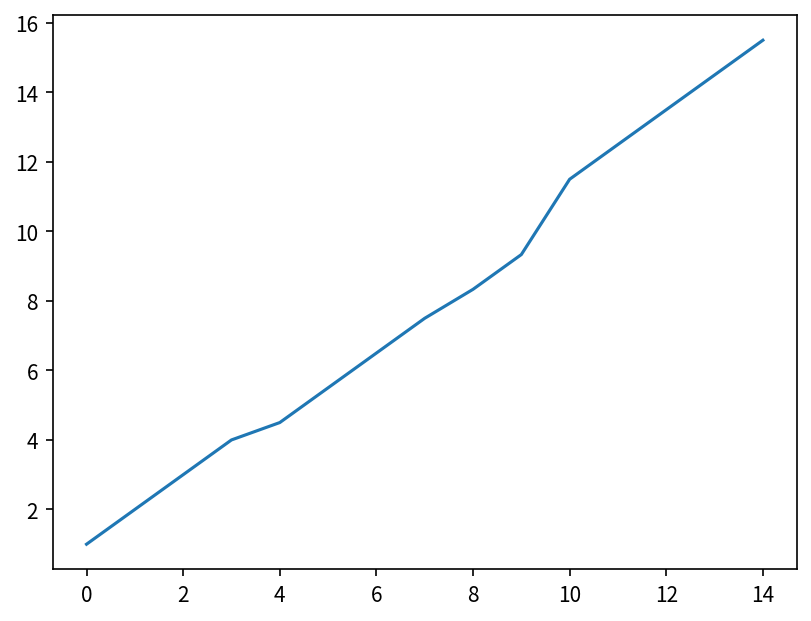

In [27]:
plot_arrival(interval, b, a)

In [28]:
G = nx.Graph()
G.add_weighted_edges_from(
    [("s", 1, 50), ("s", 2, 30), (2, 1, 20), (1, "t", 80), (2, 3, 50), (3, "t", 60)]
)
interval = [0, 2, 4, 7]  # time interval
velocity = [16, 20, 35, 20]  # velocity
for (i, j) in G.edges():
    G[i][j]["piecewise"] = arrival_func(interval, velocity, distance=G[i][j]["weight"])

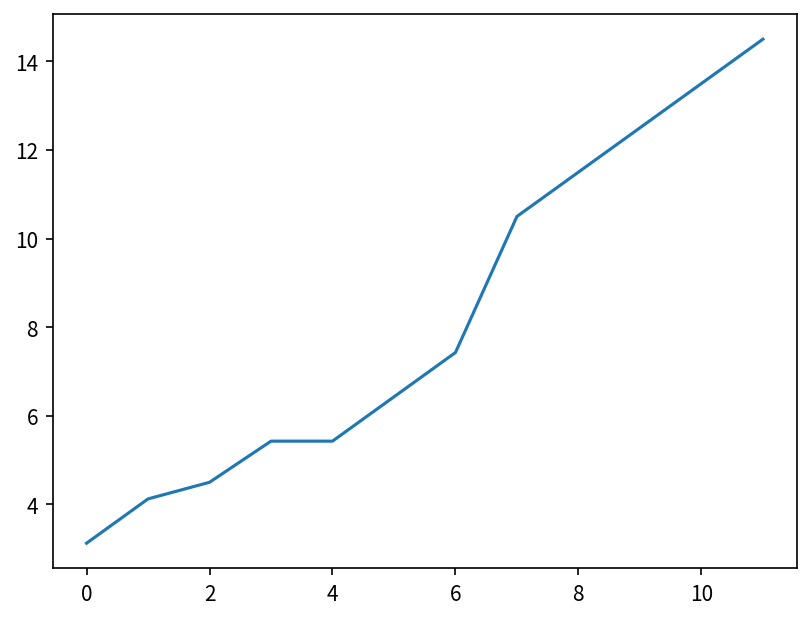

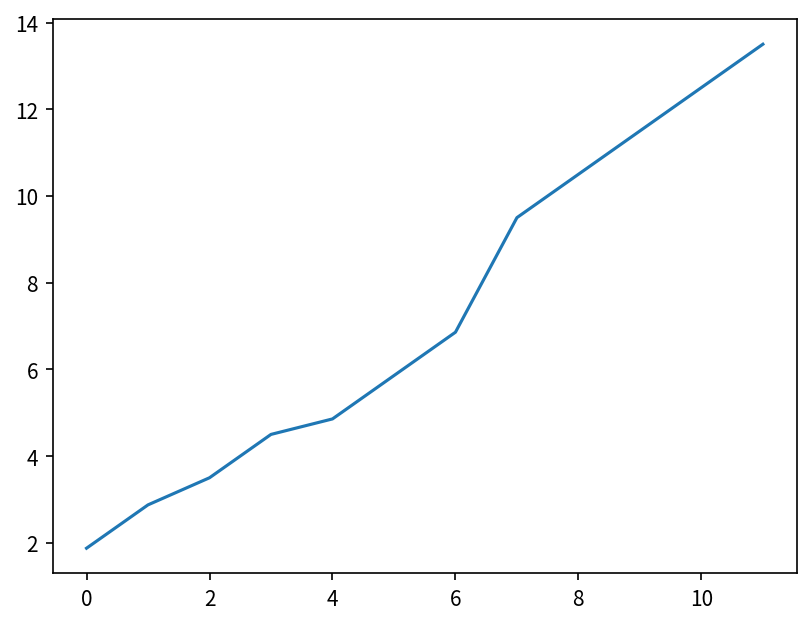

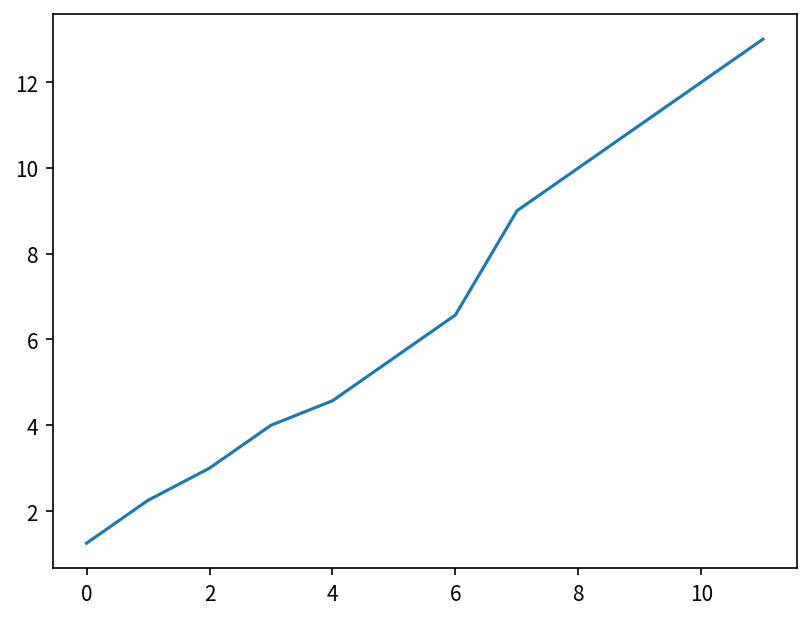

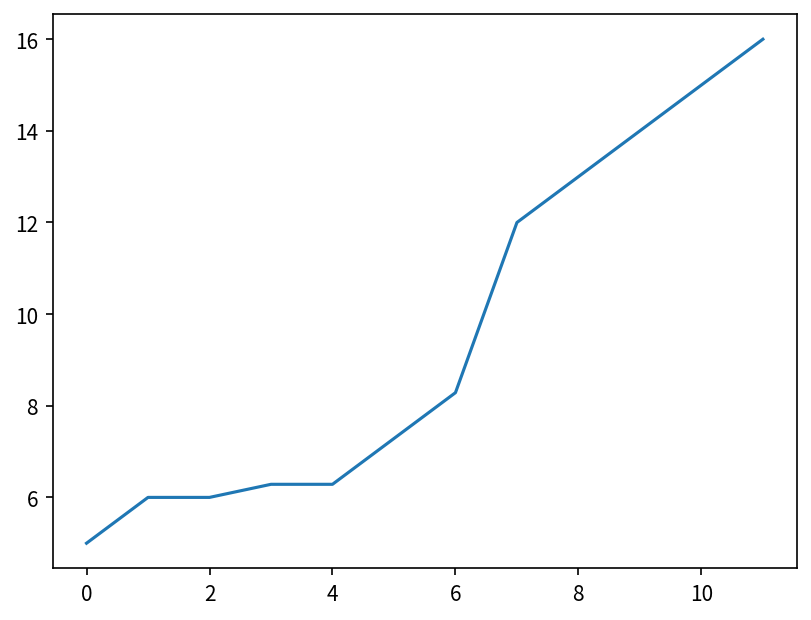

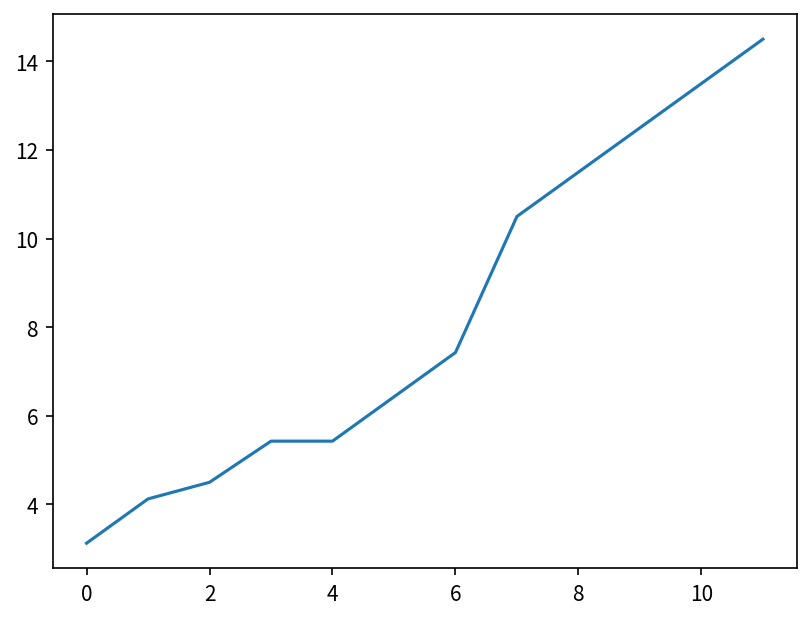

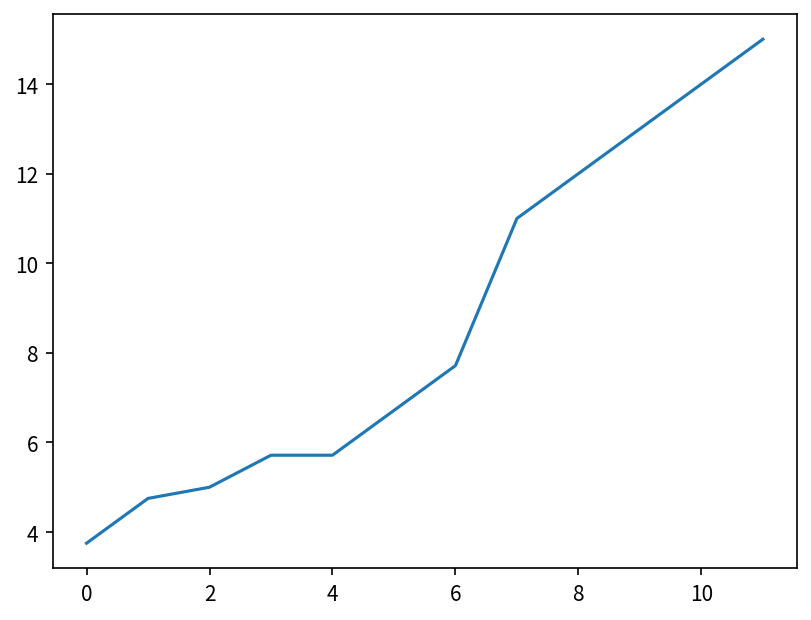

In [29]:
for (i, j) in G.edges:
    interval, b, a = G[i][j]["piecewise"]
    plot_arrival(interval, b, a)